## Isolated System, Viscosity-fixed Test

Upwelling !
Upwelling !
Upwelling !


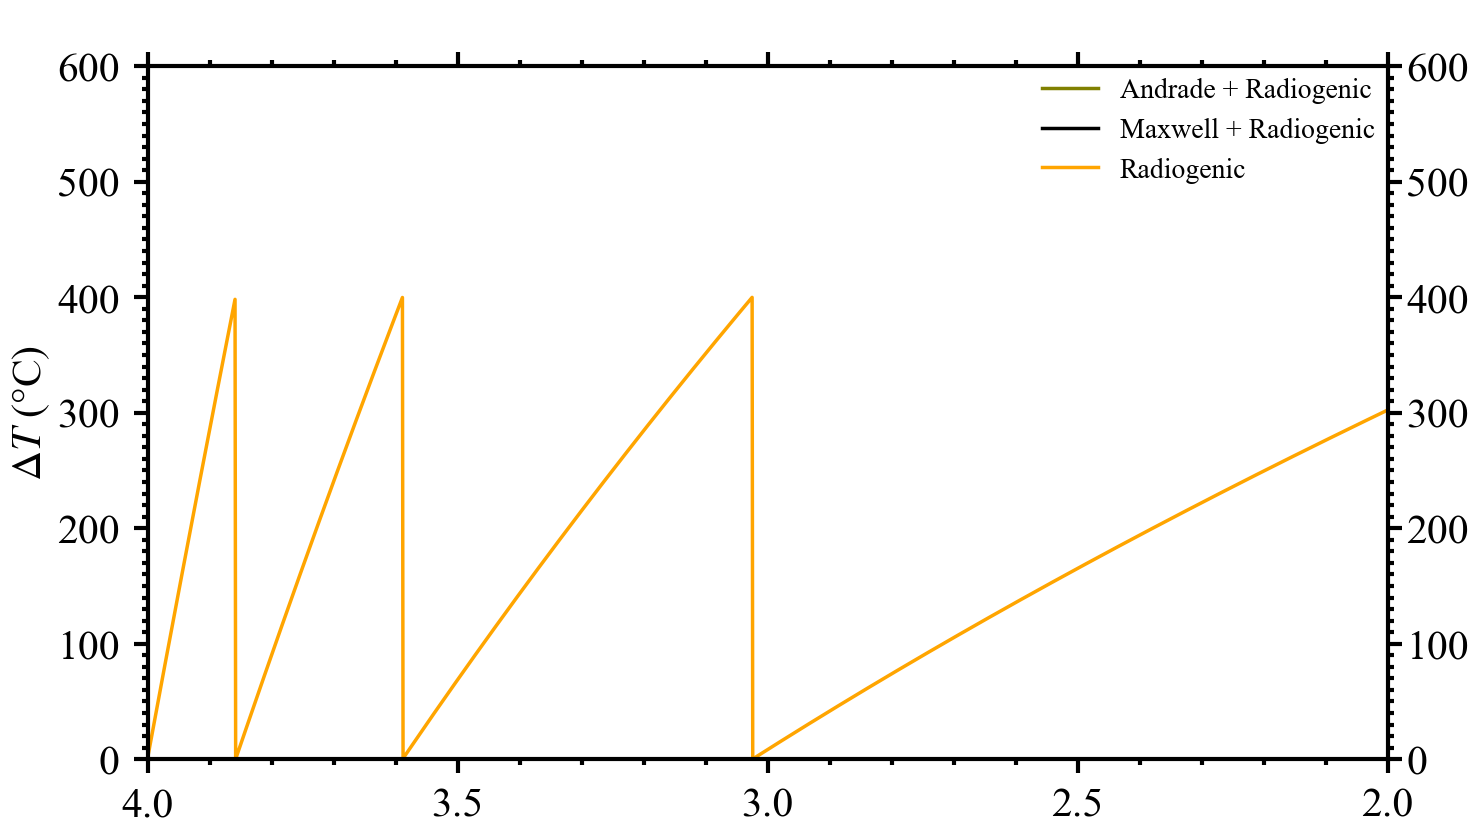

In [3]:
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK
from matplotlib.legend_handler import HandlerTuple
import numpy as NP
import os
import pandas as PD
from scipy.constants import Julian_year
import scipy.integrate as integrate
import sys
sys.path.insert(0, os.path.abspath(os.path.join('.', os.pardir)))
from tool_radiogenic_heat_production import radio_heat_production
from tool_tidal_heat_production import Layer, temporal_evolution_of_tidal_heating, func_interpolate_Earth_Moon_distance

    
class System_Thermal_Evolution(object):
    def __init__(self, Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                 radio_heating_model, tidal_heating_model, distance_model,
                 T_mic_initial, T_mantle_initial, extraction_fraction, TotalTime, timestep):
        self.Crust = Crust_Layer
        self.Mantle = Mantle_Layer
        self.LVZ = LVZ_Layer
        self.Core = Core_Layer
        self.radio_heating_model = radio_heating_model
        self.tidal_heating_model = tidal_heating_model
        self.distance_model = distance_model
        self.func_interp_a_RE = func_interpolate_Earth_Moon_distance(distance_model)
        self.initial_conditions = NP.array([T_mic_initial, T_mantle_initial])
        self.upwelling_count = 0 # Counter to track the number of upwellings
        self.extraction_fraction = extraction_fraction
        self.time = 0.0
        self.TotalTime = TotalTime
        self.timestep = timestep

    def energy_conservation_mantle(self, mantle_heating_rate):
        lhs_coef = self.Mantle.Rho * self.Mantle.Cp * self.Mantle.Volume
        dTm_dt = mantle_heating_rate * self.Mantle.Volume / lhs_coef 

        return dTm_dt
     
    def energy_conservation_mic(self, mic_heating_rate): ## name changed
        lhs_coef = self.LVZ.Rho * self.LVZ.Cp * self.LVZ.Volume
        dTm_dt = mic_heating_rate * self.LVZ.Volume / lhs_coef 
        
        return dTm_dt

    def calculate_total_heating_rate(self, time):
        

        if (self.distance_model == 'Webb1982') and (time/Julian_year/1e9 < 0.12):
            mic_tidal_heating = 0.0
            mantle_tidal_heating =0.0
        else:
            EM_Distance_RE = self.func_interp_a_RE(4.0 - time/Julian_year/1e9) ## distance （Re）
            mic_tidal_heating, mantle_tidal_heating = temporal_evolution_of_tidal_heating(EM_Distance_RE, self.tidal_heating_model, 
                                                                                          self.Crust, self.Mantle, self.LVZ, self.Core) #W/m^3
        
        mantle_radio_heating = self.Mantle.radiogenic_fraction * self.Mantle.Rho * radio_heat_production(time, self.radio_heating_model) #W/m^3
        mic_radio_heating = self.LVZ.radiogenic_fraction * self.LVZ.Rho * radio_heat_production(time, self.radio_heating_model) #W/m^3

        mic_heating_rate = mic_tidal_heating + mic_radio_heating
        mantle_heating_rate = mantle_tidal_heating + mantle_radio_heating

        ##print(f"Time = {4000 - self.time/Julian_year/1e6} Myr") ##
        ##print(f"LVZ Tidal Heating Rate = {mic_tidal_heating} W/m^3") 
        ##print(f"LVZ Radiogenic Heating Rate = {mic_radio_heating} W/m^3") 
        ##print(f"Mantle Tidal Heating Rate = {mantle_tidal_heating} W/m^3") 
        ##print(f"Mantle Radio Heating Rate = {mantle_radio_heating} W/m^3") 
        return mic_heating_rate, mantle_heating_rate
    
    def energy_balance(self, time, y):
        T_mic, T_upper_mantle = y 
        self.time = time

        if (T_mic-T_upper_mantle) > (400 * (self.upwelling_count + 1)):
            self.LVZ.radiogenic_fraction *= (1.0-self.extraction_fraction)
            self.upwelling_count +=1
            print("Upwelling !")

        mic_heating_rate, mantle_heating_rate = self.calculate_total_heating_rate(time)
        dTm_dt = self.energy_conservation_mantle(mantle_heating_rate) 
        dTmic_dt  = self.energy_conservation_mic(mic_heating_rate)

        return NP.array([dTmic_dt, dTm_dt])

    def system_solver(self):
        times = NP.linspace(0., self.TotalTime, self.timestep) 
        solution = integrate.solve_ivp(self.energy_balance, (0., self.TotalTime), self.initial_conditions, 
                                       t_eval=times, max_step=(2*self.TotalTime/self.timestep)) 
        return solution

if __name__ == "__main__":
    radius_planet = 1740.e3
    radius_cmb = 340.e3
    lvz_thickness = 300.e3
    crustal_thickness = 45.e3
    initial_Tm = 1250. + 273. 
    initial_Tlvz = 1251. + 273. 
    TotalTime = Julian_year * 2.0e9
    timestep = 2001
    RadioMode = 'TW2014'
    TidalMode = ['Andrade','Maxwell','none'][2] ##
    DistanceMode = ['Webb1982', 'Farhat2022_max', 'Daher2021_PD', 'Tyler2021_40'][0]
    entrained_KREEP_fraction = 0.45
    extraction_fraction = 0.4
    mic_radiogenic_fraction = 20*entrained_KREEP_fraction/4.5/0.189 ## HPE enrichment relative to BSM value, = 20 * entrained_KREEP_fraction / 18.9% (300 km) / 4.5 (3440)
    mantle_radiogenic_fraction = 1 - entrained_KREEP_fraction

    Crust_Layer = Layer(inner_radius=radius_planet-crustal_thickness, outer_radius=radius_planet,
                        Density=2800, Viscosity=1e25, ShearWave_Velocity=4500 , PressureWave_Velocity=8000,
                        Heat_Capacity=1250, radiogenic_fraction=0.0)
    
    Mantle_Layer = Layer(inner_radius=radius_cmb+lvz_thickness, outer_radius=radius_planet-crustal_thickness,
                        Density=3400, Viscosity=1e20,  ShearWave_Velocity=4500 , PressureWave_Velocity=8000,
                        Heat_Capacity=1250, radiogenic_fraction=mantle_radiogenic_fraction)
    
    LVZ_Layer = Layer(inner_radius=radius_cmb, outer_radius=radius_cmb+lvz_thickness,
                    Density=3440, Viscosity=1e17,  ShearWave_Velocity=3500 , PressureWave_Velocity=7000,
                    Heat_Capacity=1250, radiogenic_fraction=mic_radiogenic_fraction)
    
    Core_Layer = Layer(inner_radius=0, outer_radius=radius_cmb,
                    Density=7800, Viscosity=0.1,  ShearWave_Velocity=0.1 , PressureWave_Velocity=4000,
                    Heat_Capacity=800, radiogenic_fraction=0.0)
    
    Moon = System_Thermal_Evolution(Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                                    RadioMode, TidalMode, DistanceMode,
                                    initial_Tlvz, initial_Tm, extraction_fraction, TotalTime, timestep)

    time_before_present = NP.linspace(4.0, 2.0, timestep) 
    solution = Moon.system_solver() ##TO BE REVISED
    T_lvz = solution.y[0]
    T_mantle = solution.y[1]
    T_difference = (T_lvz - T_mantle) % 400

    #------------------#
    #Plot Configuration#
    #------------------#S
    PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
    PLT.rcParams['font.serif'] = ['Times New Roman']
    PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
    labelsize_ax = 30
    ticksize_ax = 30
    legendsize_ax = 20
    textsize_ax = 30
    linewidth_ax = 2.5
    markersize_ax = 12
    borderwidth_ax = 3
    #plot#
    fig,ax =PLT.subplots(figsize=(16,9))
    if TidalMode=='Andrade':
        ax.plot(time_before_present, T_difference , linewidth=linewidth_ax, color='olive', linestyle='-') 
    elif TidalMode=='Maxwell':
        ax.plot(time_before_present, T_difference, linewidth=linewidth_ax, color='black', linestyle='-') 
    elif TidalMode=='none':
        Radio, = ax.plot(time_before_present, T_difference, linewidth=linewidth_ax, color='orange', linestyle='-') 
        Andrade, = ax.plot([0], [0], linewidth=linewidth_ax, color='olive', linestyle='-')
        Maxwell, = ax.plot([0], [0], linewidth=linewidth_ax, color='black', linestyle='-')
        handles = [Andrade, Maxwell, Radio]
        labels = ['Andrade + Radiogenic', 'Maxwell + Radiogenic', 'Radiogenic']
        fig.legend(handles, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, 
            bbox_to_anchor=(1.01,1.02),bbox_transform=ax.transAxes,
            edgecolor='none',facecolor='none',fontsize=legendsize_ax)
    #------------------------------#
    #Universal Figure configuration#
    #------------------------------#
    ax.set_xlim(4.0,2.0)
    ax.set_ylim(0,600)
    ax.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(TICK.MultipleLocator(100))
    ax.yaxis.set_minor_locator(TICK.MultipleLocator(10))
    ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
    ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
    #ax.set_xlabel(r"Time Before Present (Ga)",fontsize=labelsize_ax)
    ax.set_ylabel(r"$\Delta T$ (°C)",fontsize=labelsize_ax) 
    ## top x axis
    ax2=ax.twiny()
    ax2.set_xlim(4.0,2.0)
    ax2.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
    ax2.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
    ax2.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,labelcolor='none',width=borderwidth_ax)
    ax2.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
    ## right y axis
    ax3=ax.twinx()
    ax3.set_ylim(0,600) 
    ax3.yaxis.set_major_locator(TICK.MultipleLocator(100))
    ax3.yaxis.set_minor_locator(TICK.MultipleLocator(10))
    ax3.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,width=borderwidth_ax)
    ax3.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
    ## overall setting
    for border in ['top', 'bottom', 'left', 'right']:
        ax.spines[border].set_linewidth(borderwidth_ax)
    fig.savefig(f"SubFigure_{TidalMode}_{DistanceMode}_Entrain{entrained_KREEP_fraction*100:.2g}%_Extract{extraction_fraction*100:.2g}%.pdf",bbox_inches='tight',transparent=True) 
    PLT.show()

## Isolated System, Viscosity-fixed Test, Parallel Version

In [4]:
import concurrent.futures
import itertools
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK
from matplotlib.legend_handler import HandlerTuple
import numpy as NP
import os
import pandas as PD
import random
from scipy.constants import Julian_year
import scipy.integrate as integrate
import sys
sys.path.insert(0, os.path.abspath(os.path.join('.', os.pardir)))
from tool_radiogenic_heat_production import radio_heat_production
from tool_tidal_heat_production import Layer, temporal_evolution_of_tidal_heating, func_interpolate_Earth_Moon_distance

    
class System_Thermal_Evolution(object):
    def __init__(self, Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                 radio_heating_model, tidal_heating_model, distance_model,
                 T_mic_initial, T_mantle_initial, extraction_fraction, TotalTime, timestep):
        self.Crust = Crust_Layer
        self.Mantle = Mantle_Layer
        self.LVZ = LVZ_Layer
        self.Core = Core_Layer
        self.radio_heating_model = radio_heating_model
        self.tidal_heating_model = tidal_heating_model
        self.distance_model = distance_model
        self.func_interp_a_RE = func_interpolate_Earth_Moon_distance(distance_model)
        self.initial_conditions = NP.array([T_mic_initial, T_mantle_initial])
        self.upwelling_count = 0 # Counter to track the number of upwellings
        self.extraction_fraction = extraction_fraction
        self.time = 0.0
        self.TotalTime = TotalTime
        self.timestep = timestep

    def energy_conservation_mantle(self, mantle_heating_rate):
        lhs_coef = self.Mantle.Rho * self.Mantle.Cp * self.Mantle.Volume
        dTm_dt = mantle_heating_rate * self.Mantle.Volume / lhs_coef 

        return dTm_dt
     
    def energy_conservation_mic(self, mic_heating_rate): ## name changed
        lhs_coef = self.LVZ.Rho * self.LVZ.Cp * self.LVZ.Volume
        dTm_dt = mic_heating_rate * self.LVZ.Volume / lhs_coef 
        
        return dTm_dt

    def calculate_total_heating_rate(self, time):
        

        if (self.distance_model == 'Webb1982') and (time/Julian_year/1e9 < 0.12):
            mic_tidal_heating = 0.0
            mantle_tidal_heating =0.0
        else:
            EM_Distance_RE = self.func_interp_a_RE(4.0 - time/Julian_year/1e9) ## distance （Re）
            mic_tidal_heating, mantle_tidal_heating = temporal_evolution_of_tidal_heating(EM_Distance_RE, self.tidal_heating_model, 
                                                                                          self.Crust, self.Mantle, self.LVZ, self.Core) #W/m^3
        
        mantle_radio_heating = self.Mantle.radiogenic_fraction * self.Mantle.Rho * radio_heat_production(time, self.radio_heating_model) #W/m^3
        mic_radio_heating = self.LVZ.radiogenic_fraction * self.LVZ.Rho * radio_heat_production(time, self.radio_heating_model) #W/m^3

        mic_heating_rate = mic_tidal_heating + mic_radio_heating
        mantle_heating_rate = mantle_tidal_heating + mantle_radio_heating

        ##print(f"Time = {4000 - self.time/Julian_year/1e6} Myr") ##
        ##print(f"LVZ Tidal Heating Rate = {mic_tidal_heating} W/m^3") 
        ##print(f"LVZ Radiogenic Heating Rate = {mic_radio_heating} W/m^3") 
        ##print(f"Mantle Tidal Heating Rate = {mantle_tidal_heating} W/m^3") 
        ##print(f"Mantle Radio Heating Rate = {mantle_radio_heating} W/m^3") 
        return mic_heating_rate, mantle_heating_rate
    
    def energy_balance(self, time, y):
        T_mic, T_upper_mantle = y 
        self.time = time

        if (T_mic-T_upper_mantle) > (400 * (self.upwelling_count + 1)):
            self.LVZ.radiogenic_fraction *= (1.0-self.extraction_fraction)
            self.upwelling_count +=1
            print("Upwelling !")

        mic_heating_rate, mantle_heating_rate = self.calculate_total_heating_rate(time)
        dTm_dt = self.energy_conservation_mantle(mantle_heating_rate) 
        dTmic_dt  = self.energy_conservation_mic(mic_heating_rate)

        return NP.array([dTmic_dt, dTm_dt])

    def system_solver(self):
        times = NP.linspace(0., self.TotalTime, self.timestep) 
        solution = integrate.solve_ivp(self.energy_balance, (0., self.TotalTime), self.initial_conditions, 
                                       t_eval=times, max_step=(2*self.TotalTime/self.timestep)) 
        return solution

def Eruption_Episode_PhaseGraph(input_params):
    TidalMode, DistanceMode = input_params
    print(f"Processing {TidalMode}, {DistanceMode}")
    radius_planet = 1740.e3
    radius_cmb = 340.e3
    lvz_thickness = 300.e3
    crustal_thickness = 45.e3
    initial_Tm = 1250. + 273. 
    initial_Tlvz = 1251. + 273. 
    TotalTime = Julian_year * 2.0e9
    timestep = 2001
    RadioMode = 'TW2014'    

    Path_subfigures = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}" 
    try:
        os.makedirs(Path_subfigures, exist_ok=True)
        print(f"Directory '{Path_subfigures}' created successfully.")
    except OSError as error:
        print(f"Error creating directory '{Path_subfigures}': {error}")

    list_eruption_number = []

    for extraction_fraction in [0.2, 0.3, 0.4, 0.5, 0.6]:
        for entrained_KREEP_fraction in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:

            mic_radiogenic_fraction = 20*entrained_KREEP_fraction/4.5/0.189 ## HPE enrichment relative to BSM value, = 20 * entrained_KREEP_fraction / 18.9% (300 km) / 4.5 (3440)
            mantle_radiogenic_fraction = 1 - entrained_KREEP_fraction
    
            Crust_Layer = Layer(inner_radius=radius_planet-crustal_thickness, outer_radius=radius_planet,
                                Density=2800, Viscosity=1e25, ShearWave_Velocity=4500 , PressureWave_Velocity=8000,
                                Heat_Capacity=1250, radiogenic_fraction=0.0)
            
            Mantle_Layer = Layer(inner_radius=radius_cmb+lvz_thickness, outer_radius=radius_planet-crustal_thickness,
                                Density=3400, Viscosity=1e20,  ShearWave_Velocity=4500 , PressureWave_Velocity=8000,
                                Heat_Capacity=1250, radiogenic_fraction=mantle_radiogenic_fraction)
            
            LVZ_Layer = Layer(inner_radius=radius_cmb, outer_radius=radius_cmb+lvz_thickness,
                            Density=3440, Viscosity=1e17,  ShearWave_Velocity=3500 , PressureWave_Velocity=7000,
                            Heat_Capacity=1250, radiogenic_fraction=mic_radiogenic_fraction)
            
            Core_Layer = Layer(inner_radius=0, outer_radius=radius_cmb,
                            Density=7800, Viscosity=0.1,  ShearWave_Velocity=0.1 , PressureWave_Velocity=4000,
                            Heat_Capacity=800, radiogenic_fraction=0.0)
            
            Moon = System_Thermal_Evolution(Crust_Layer, Mantle_Layer, LVZ_Layer, Core_Layer, 
                                            RadioMode, TidalMode, DistanceMode,
                                            initial_Tlvz, initial_Tm, extraction_fraction, TotalTime, timestep)

            time_before_present = NP.linspace(4.0, 2.0, timestep) 
            solution = Moon.system_solver() ##TO BE REVISED
            T_lvz = solution.y[0]
            T_mantle = solution.y[1]
            T_difference = (T_lvz - T_mantle) % 400

            #------------------#
            #Plot Configuration#
            #------------------#S
            PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
            PLT.rcParams['font.serif'] = ['Times New Roman']
            PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
            labelsize_ax = 30
            ticksize_ax = 30
            legendsize_ax = 20
            textsize_ax = 30
            linewidth_ax = 2.5
            markersize_ax = 12
            borderwidth_ax = 3
            #plot#
            fig,ax =PLT.subplots(figsize=(12,8))
            if TidalMode=='Andrade':
                ax.plot(time_before_present, T_difference , linewidth=linewidth_ax, color='olive', linestyle='-') 
            elif TidalMode=='Maxwell':
                ax.plot(time_before_present, T_difference, linewidth=linewidth_ax, color='black', linestyle='-') 
            elif TidalMode=='none':
                Radio, = ax.plot(time_before_present, T_difference, linewidth=linewidth_ax, color='orange', linestyle='-') 
                Andrade, = ax.plot([0], [0], linewidth=linewidth_ax, color='olive', linestyle='-')
                Maxwell, = ax.plot([0], [0], linewidth=linewidth_ax, color='black', linestyle='-')
                handles = [Andrade, Maxwell, Radio]
                labels = ['Andrade + Radiogenic', 'Maxwell + Radiogenic', 'Radiogenic']
                fig.legend(handles, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, 
                    bbox_to_anchor=(1.01,1.02),bbox_transform=ax.transAxes,
                    edgecolor='none',facecolor='none',fontsize=legendsize_ax)
            #------------------------------#
            #Universal Figure configuration#
            #------------------------------#
            ax.set_xlim(4.0,2.0)
            ax.set_ylim(0,600)
            ax.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
            ax.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
            ax.yaxis.set_major_locator(TICK.MultipleLocator(100))
            ax.yaxis.set_minor_locator(TICK.MultipleLocator(10))
            ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
            ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
            #ax.set_xlabel(r"Time Before Present (Ga)",fontsize=labelsize_ax)
            ax.set_ylabel(r"$\Delta T$ (°C)",fontsize=labelsize_ax) 
            ## top x axis
            ax2=ax.twiny()
            ax2.set_xlim(4.0,2.0)
            ax2.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
            ax2.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
            ax2.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,labelcolor='none',width=borderwidth_ax)
            ax2.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
            ## right y axis
            ax3=ax.twinx()
            ax3.set_ylim(0,600) 
            ax3.yaxis.set_major_locator(TICK.MultipleLocator(100))
            ax3.yaxis.set_minor_locator(TICK.MultipleLocator(10))
            ax3.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,width=borderwidth_ax)
            ax3.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
            ## overall setting
            for border in ['top', 'bottom', 'left', 'right']:
                ax.spines[border].set_linewidth(borderwidth_ax)
            fig.savefig(f"{Path_subfigures}/SubFigure_a_{TidalMode}_{DistanceMode}_Entrain{entrained_KREEP_fraction*100:.2g}%_Extract{extraction_fraction*100:.2g}%.pdf",bbox_inches='tight',transparent=True) 
            #PLT.show()
            list_eruption_number.append(Moon.upwelling_count)
    

    #output the eruption number#
    df_eruption_number = PD.DataFrame(list_eruption_number, index=[0.2, 0.3, 0.4, 0.5, 0.6], columns=[0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    output_file = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}.xlsx"
    df_eruption_number.to_excel(output_file)
    return output_file

def execute_in_parallel(input_params):
    with concurrent.futures.ProcessPoolExecutor(max_workers=12) as executor:
        output_file = executor.map(Eruption_Episode_PhaseGraph, input_params)
    return f"{output_file} successfully written"


if __name__ == "__main__":
    TidalMode = ['Andrade','Maxwell','none']
    DistanceMode = ['Webb1982', 'Farhat2022_max', 'Daher2021_PD', 'Tyler2021_40']
    All_Parameters_Combination = list(itertools.product(TidalMode, DistanceMode))
    Input_Params_Selected = random.sample(All_Parameters_Combination, 12)
    print(All_Parameters_Combination)
    flag = execute_in_parallel(Input_Params_Selected)
    print(flag)


[('Andrade', 'Webb1982'), ('Andrade', 'Farhat2022_max'), ('Andrade', 'Daher2021_PD'), ('Andrade', 'Tyler2021_40'), ('Maxwell', 'Webb1982'), ('Maxwell', 'Farhat2022_max'), ('Maxwell', 'Daher2021_PD'), ('Maxwell', 'Tyler2021_40'), ('none', 'Webb1982'), ('none', 'Farhat2022_max'), ('none', 'Daher2021_PD'), ('none', 'Tyler2021_40')]
Processing Maxwell, Tyler2021_40Processing Andrade, Webb1982Processing Andrade, Daher2021_PDProcessing Maxwell, Daher2021_PDProcessing Maxwell, Farhat2022_maxProcessing none, Daher2021_PD
Processing Andrade, Farhat2022_max
Processing none, Webb1982

Processing none, Tyler2021_40Processing none, Farhat2022_max



Directory 'SubFigure_PhaseGraph/Andrade_Daher2021_PD' created successfully.Processing Andrade, Tyler2021_40Directory 'SubFigure_PhaseGraph/Maxwell_Tyler2021_40' created successfully.Directory 'SubFigure_PhaseGraph/Andrade_Webb1982' created successfully.Directory 'SubFigure_PhaseGraph/Maxwell_Daher2021_PD' created successfully.Processing Maxwell, Webb198

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting comp

Upwelling !

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !Upwelling !

Upwelling !
Upwelling !
Upwelling !Upwelling !

Upwelling !
Upwelling !
Upwelling !Upwelling !

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwe

/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax =PLT.subplots(figsize=(12,8))
/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax =PLT.subplots(figsize=(12,8))
/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may

Upwelling !
Upwelling !Upwelling !

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwe

/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax =PLT.subplots(figsize=(12,8))
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore File

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax =PLT.subplots(figsize=(12,8))
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore File

Upwelling !
Upwelling !


/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax =PLT.subplots(figsize=(12,8))
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore File

Upwelling !
Upwelling !
Upwelling !


/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax =PLT.subplots(figsize=(12,8))
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore File

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/tmp/ipykernel_280749/1187334652.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax =PLT.subplots(figsize=(12,8))
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore File

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting comp

Upwelling !
Upwelling !


/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:230: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
/home/wbzhang/Nutstore Files/Nutstore/Tidal heating项目/Part4_月幔温度演化/tool_tidal_heat_production.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
Upwelling !
<generator object _chain_from_iterable_of_lists at 0x70a960469b30> successfully written


### Phase Graph: Andrade+Webb1982

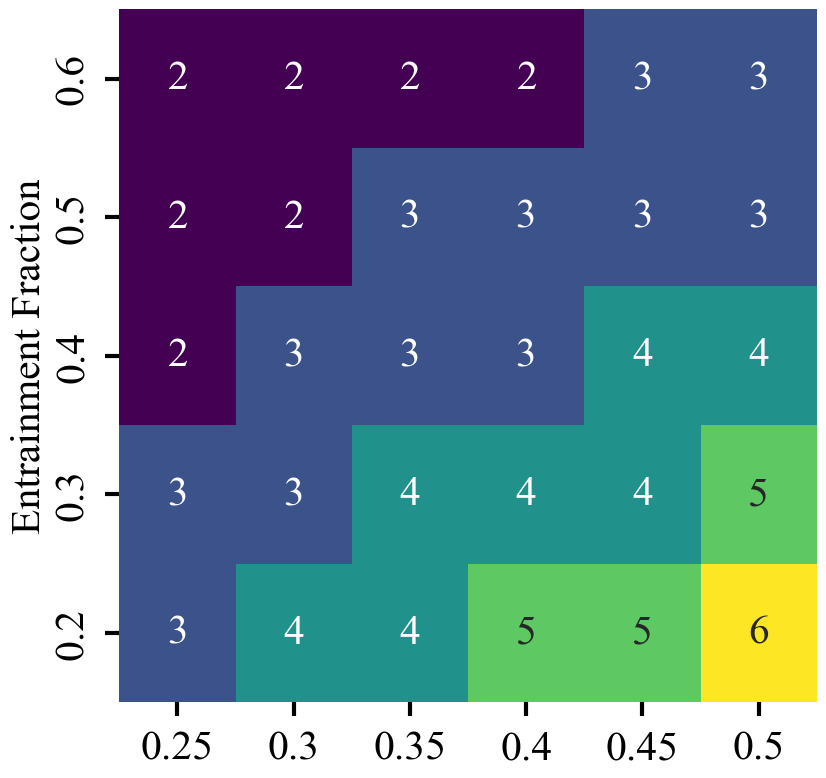

In [1]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK

# Read the Excel file
TidalMode = 'Andrade'
DistanceMode = 'Webb1982'
file_path = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}/{TidalMode}_{DistanceMode}.xlsx"  # Replace with your actual file path
data = PD.read_excel(file_path)

heatmap_data = data.set_index('Unnamed: 0')
heatmap_data_sorted = heatmap_data.sort_index(ascending=False)
#------------------#
#Plot Configuration#
#------------------#S
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3
# Create a heatmap using seaborn
fig,ax =PLT.subplots(figsize=(9,9))
##SNS.heatmap(heatmap_data, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax})
SNS.heatmap(heatmap_data_sorted, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax}, cbar=False, vmin=2, vmax=6)

ax.set_xlabel('', fontsize=labelsize_ax)
ax.set_ylabel('Entrainment Fraction', fontsize=labelsize_ax)
ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
# Show the plot
PLT.show()
fig.savefig(f"SubFigure_{TidalMode}_{DistanceMode}.pdf",bbox_inches='tight',transparent=True) 

### Phase Graph: Maxwell+Webb1982

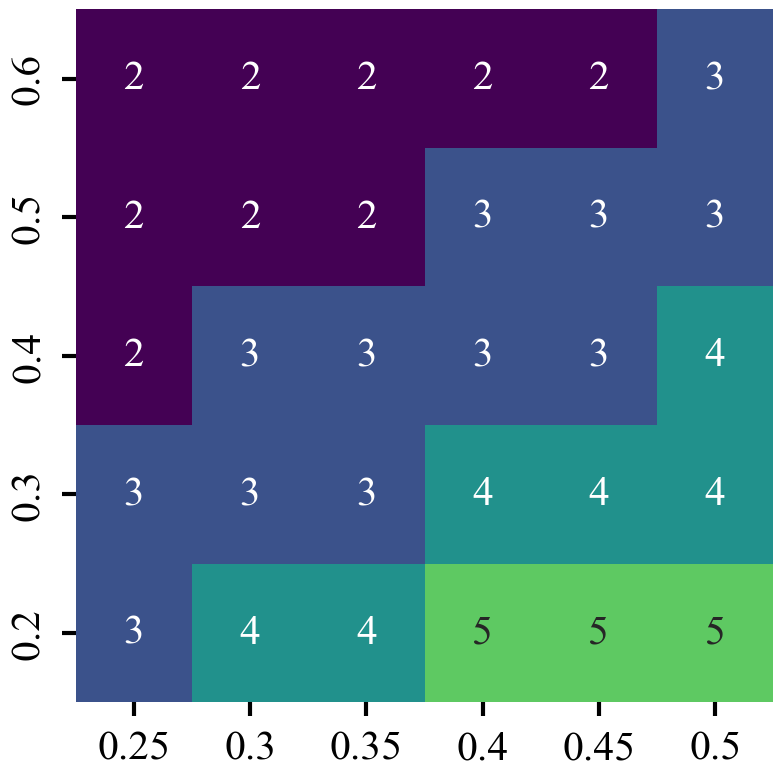

In [10]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK

# Read the Excel file
TidalMode = 'Maxwell'
DistanceMode = 'Webb1982'
file_path = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}/{TidalMode}_{DistanceMode}.xlsx"  # Replace with your actual file path
data = PD.read_excel(file_path)

heatmap_data = data.set_index('Unnamed: 0')
heatmap_data_sorted = heatmap_data.sort_index(ascending=False)
#------------------#
#Plot Configuration#
#------------------#S
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3
# Create a heatmap using seaborn
fig,ax =PLT.subplots(figsize=(9,9))
##SNS.heatmap(heatmap_data, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax})
SNS.heatmap(heatmap_data_sorted, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax}, cbar=False,  vmin=2, vmax=6)

ax.set_xlabel('', fontsize=labelsize_ax)
ax.set_ylabel('')
ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
# Show the plot
PLT.show()
fig.savefig(f"SubFigure_{TidalMode}_{DistanceMode}.pdf",bbox_inches='tight',transparent=True) 

### Phase Graph: Radiogenic Only

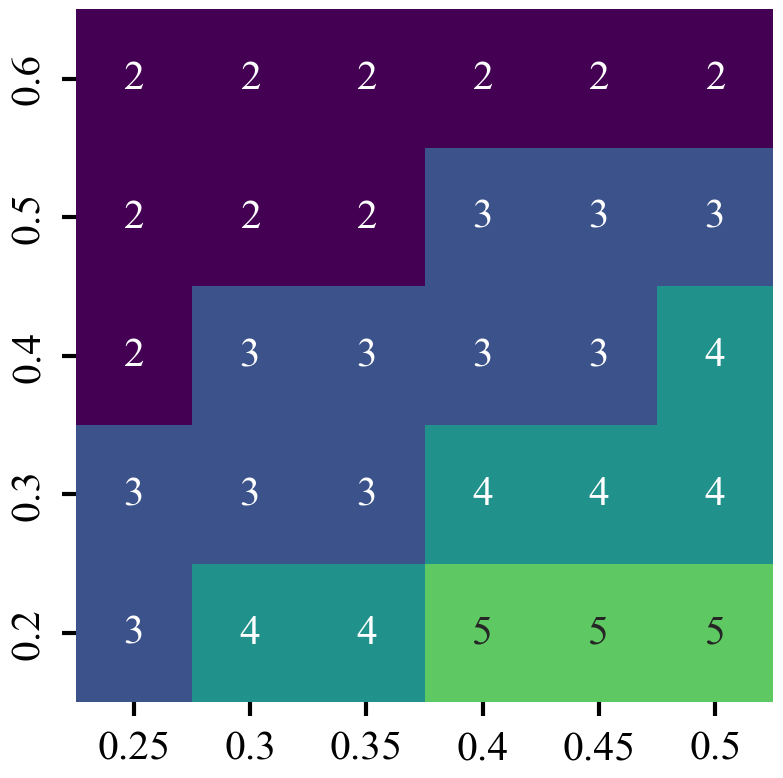

In [12]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK

# Read the Excel file
TidalMode = 'none'
DistanceMode = 'Webb1982'
file_path = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}/{TidalMode}_{DistanceMode}.xlsx"  # Replace with your actual file path
data = PD.read_excel(file_path)

heatmap_data = data.set_index('Unnamed: 0')
heatmap_data_sorted = heatmap_data.sort_index(ascending=False)
#------------------#
#Plot Configuration#
#------------------#S
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3
# Create a heatmap using seaborn
fig,ax =PLT.subplots(figsize=(9,9))
##SNS.heatmap(heatmap_data, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax})
SNS.heatmap(heatmap_data_sorted, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax}, cbar=False, vmin=2, vmax=6)

ax.set_xlabel('', fontsize=labelsize_ax)
ax.set_ylabel('')
ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
# Show the plot
PLT.show()
fig.savefig(f"SubFigure_{TidalMode}_{DistanceMode}.pdf",bbox_inches='tight',transparent=True) 

### Phase Graph: Andrade+Farhat2022max

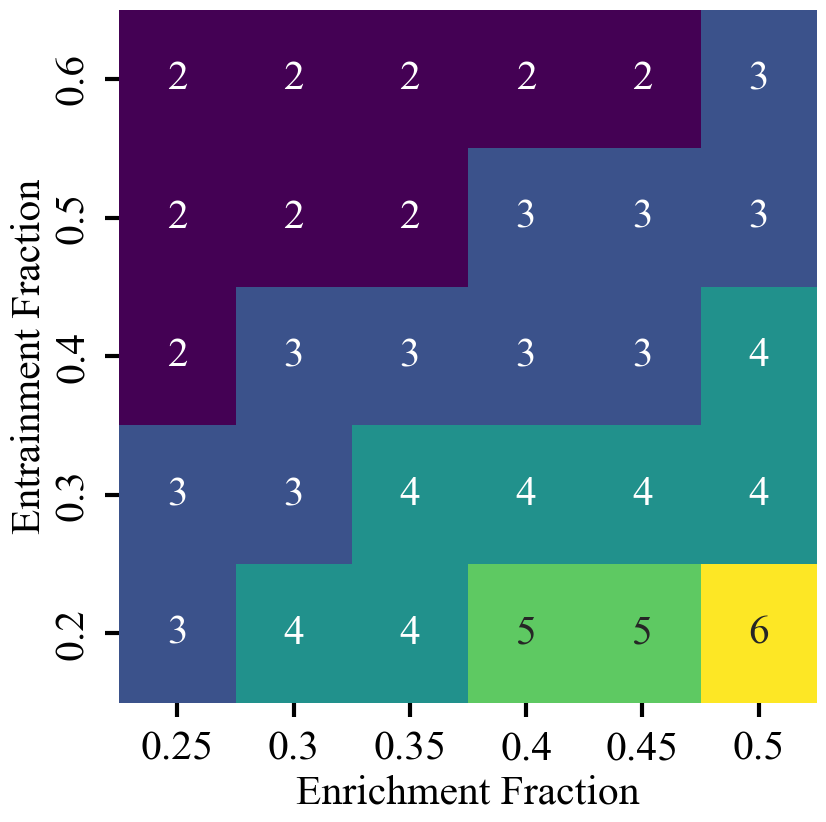

In [2]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK

# Read the Excel file
TidalMode = 'Andrade'
DistanceMode = 'Farhat2022_max'
file_path = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}/{TidalMode}_{DistanceMode}.xlsx"  # Replace with your actual file path
data = PD.read_excel(file_path)

heatmap_data = data.set_index('Unnamed: 0')
heatmap_data_sorted = heatmap_data.sort_index(ascending=False)
#------------------#
#Plot Configuration#
#------------------#S
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3
# Create a heatmap using seaborn
fig,ax =PLT.subplots(figsize=(9,9))
##SNS.heatmap(heatmap_data, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax})
SNS.heatmap(heatmap_data_sorted, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax}, cbar=False, vmin=2, vmax=6)

ax.set_xlabel('Enrichment Fraction', fontsize=labelsize_ax)
ax.set_ylabel('Entrainment Fraction', fontsize=labelsize_ax)
ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
# Show the plot
PLT.show()
fig.savefig(f"SubFigure_{TidalMode}_{DistanceMode}.pdf",bbox_inches='tight',transparent=True) 

### Phase Graph: Andrade+Daher2021_PD

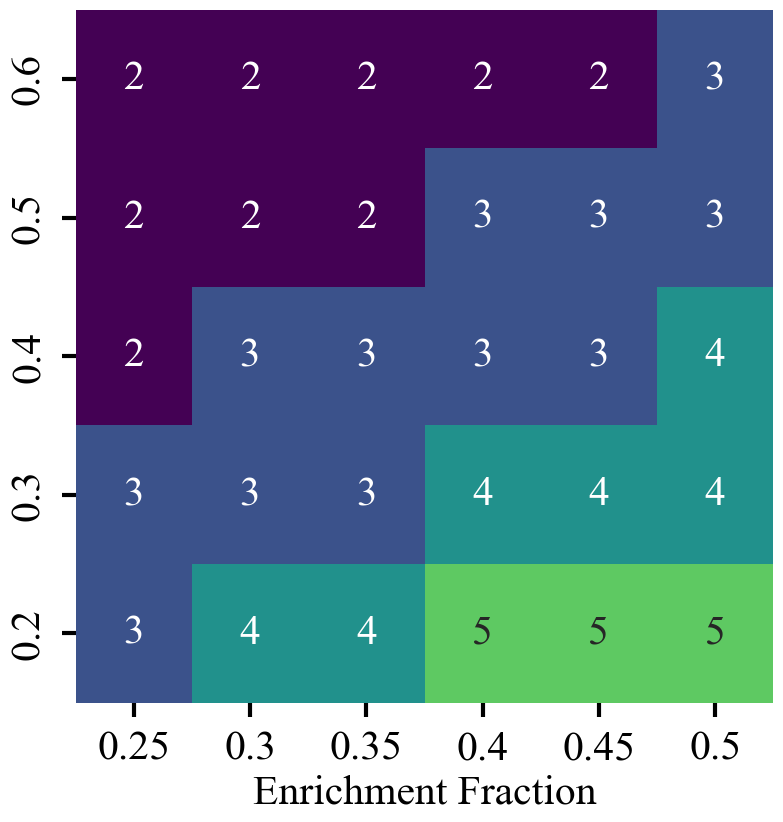

In [4]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK

# Read the Excel file
TidalMode = 'Andrade'
DistanceMode = 'Daher2021_PD'
file_path = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}/{TidalMode}_{DistanceMode}.xlsx"  # Replace with your actual file path
data = PD.read_excel(file_path)

heatmap_data = data.set_index('Unnamed: 0')
heatmap_data_sorted = heatmap_data.sort_index(ascending=False)
#------------------#
#Plot Configuration#
#------------------#S
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3
# Create a heatmap using seaborn
fig,ax =PLT.subplots(figsize=(9,9))
##SNS.heatmap(heatmap_data, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax})
SNS.heatmap(heatmap_data_sorted, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax}, cbar=False, vmin=2, vmax=6)

ax.set_xlabel('Enrichment Fraction', fontsize=labelsize_ax)
ax.set_ylabel('', fontsize=labelsize_ax)
ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
# Show the plot
PLT.show()
fig.savefig(f"SubFigure_{TidalMode}_{DistanceMode}.pdf",bbox_inches='tight',transparent=True) 

### Phase Graph: Andrade+Tyler2021_40

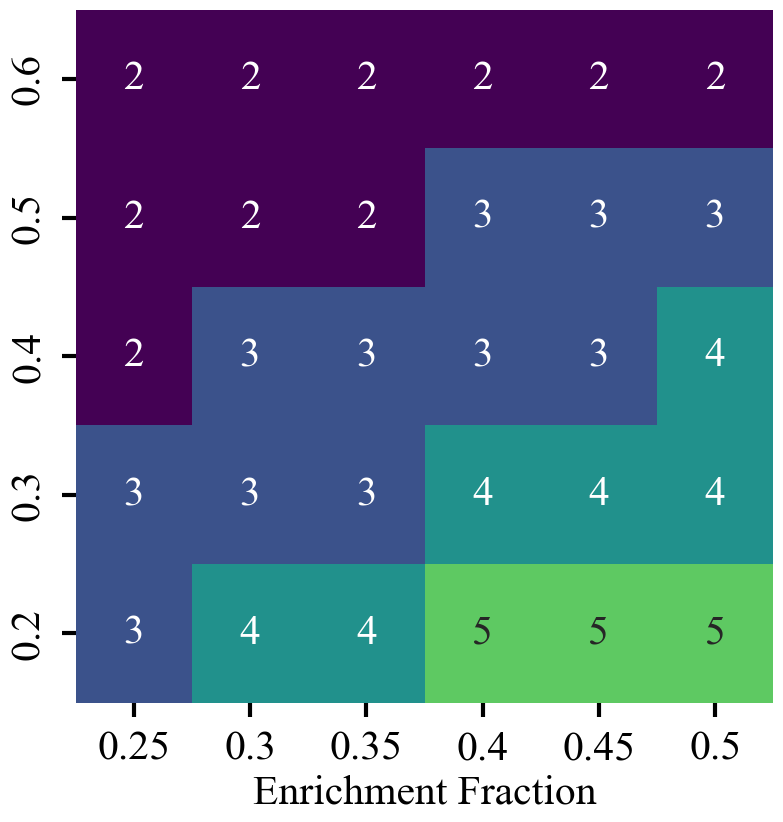

In [3]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK

# Read the Excel file
TidalMode = 'Andrade'
DistanceMode = 'Tyler2021_40'
file_path = f"SubFigure_PhaseGraph/{TidalMode}_{DistanceMode}/{TidalMode}_{DistanceMode}.xlsx"  # Replace with your actual file path
data = PD.read_excel(file_path)

heatmap_data = data.set_index('Unnamed: 0')
heatmap_data_sorted = heatmap_data.sort_index(ascending=False)
#------------------#
#Plot Configuration#
#------------------#S
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3
# Create a heatmap using seaborn
fig,ax =PLT.subplots(figsize=(9,9))
##SNS.heatmap(heatmap_data, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax})
SNS.heatmap(heatmap_data_sorted, annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize": textsize_ax}, cbar=False, vmin=2, vmax=6)

ax.set_xlabel('Enrichment Fraction', fontsize=labelsize_ax)
ax.set_ylabel('', fontsize=labelsize_ax)
ax.tick_params(axis='both',direction='out',length=10, labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
# Show the plot
PLT.show()
fig.savefig(f"SubFigure_{TidalMode}_{DistanceMode}.pdf",bbox_inches='tight',transparent=True) 